# Predicting Seasonal Flu vaccination refusal using best features 
## Features selected from XGBoost Classifier

This notebook uses 15 best features as selected using as XGBoost Classifier. The features are listed below:
* `doctor_recc_seasonal`
* `opinion_seas_vacc_effective`
* `opinion_seas_risk`
* `age_group`
* `health_insurance`
* `health_worker`
* `rent_or_own`
* `employment_industry`
* `h1n1_knowledge`
* `doctor_recc_h1n1`
* `employment_occupation`
* `opinion_seas_sick_from_vacc`
* `chronic_med_condition`
* `opinion_h1n1_risk`
* `education`
* `h1n1_vaccine`
* `seasonal_vaccine`

The notebook runs a single model using these fifteen features as is with the XGBoost model that was optimized in the previous notebook. 

The results comparing metrics when using all features vs only the top 15 are below: 

Metric | With all features | With top 15 features
-------|-------------------|--------------------
Accuracy|0.797| 0.849
Precision|0.800| 0.873
Recall| 0.825 | 0.956
Roc_Auc| 0.794| 0.717

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, recall_score, precision_score, 
                            roc_auc_score, balanced_accuracy_score, ConfusionMatrixDisplay)

C:\ProgramData\Anaconda3\envs\xgboost\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Using top features from XGBoost

In [2]:
# import data
data = pd.read_csv('../data/train_clean.csv')

In [3]:
data.columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation', 'h1n1_vaccine', 'seasonal_vaccine'],
      dtype='object')

In [4]:
data['h1n1_vaccine'].value_counts(normalize=True)

0    0.787546
1    0.212454
Name: h1n1_vaccine, dtype: float64

In [5]:
data['seasonal_vaccine'].value_counts(normalize=True)

0    0.534392
1    0.465608
Name: seasonal_vaccine, dtype: float64

In [6]:
# since we're interested in the people who did not get vaccinated: switch 0 and 1 labels
data['h1n1_vaccine'].replace({1:0, 0:1}, inplace=True)
data['h1n1_vaccine'].value_counts()

data['seasonal_vaccine'].replace({1:0, 0:1}, inplace=True)
data['seasonal_vaccine'].value_counts()

1    14272
0    12435
Name: seasonal_vaccine, dtype: int64

In [12]:
features_to_use = pd.read_csv('../data/XGB_seasonal_feature_imp.csv')

In [13]:
features = list(features_to_use['feature'])
features.append('h1n1_vaccine')
features.append('seasonal_vaccine')
features

['doctor_recc_seasonal',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'age_group',
 'health_insurance',
 'health_worker',
 'rent_or_own',
 'employment_industry',
 'h1n1_knowledge',
 'doctor_recc_h1n1',
 'employment_occupation',
 'opinion_seas_sick_from_vacc',
 'chronic_med_condition',
 'opinion_h1n1_risk',
 'education',
 'h1n1_vaccine',
 'seasonal_vaccine']

In [14]:
data = data[features]

In [15]:
data.columns

Index(['doctor_recc_seasonal', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'age_group', 'health_insurance', 'health_worker',
       'rent_or_own', 'employment_industry', 'h1n1_knowledge',
       'doctor_recc_h1n1', 'employment_occupation',
       'opinion_seas_sick_from_vacc', 'chronic_med_condition',
       'opinion_h1n1_risk', 'education', 'h1n1_vaccine', 'seasonal_vaccine'],
      dtype='object')

**dummify x**

In [16]:
categorical_columns = list(data.select_dtypes('object').columns)
categorical_columns

['doctor_recc_seasonal',
 'age_group',
 'health_insurance',
 'health_worker',
 'rent_or_own',
 'employment_industry',
 'doctor_recc_h1n1',
 'employment_occupation',
 'chronic_med_condition',
 'education']

In [17]:
X = pd.get_dummies(data=data.drop(columns=['h1n1_vaccine', 'seasonal_vaccine']),
                    columns=categorical_columns, drop_first=True)

**define X and y**

In [18]:
X.columns

Index(['opinion_seas_vacc_effective', 'opinion_seas_risk', 'h1n1_knowledge',
       'opinion_seas_sick_from_vacc', 'opinion_h1n1_risk',
       'doctor_recc_seasonal_1.0', 'doctor_recc_seasonal_no_response',
       'age_group_35 - 44 Years', 'age_group_45 - 54 Years',
       'age_group_55 - 64 Years', 'age_group_65+ Years',
       'health_insurance_no_response', 'health_insurance_yes',
       'health_worker_no_response', 'health_worker_yes', 'rent_or_own_Rent',
       'rent_or_own_no_response', 'employment_industry_atmlpfrs',
       'employment_industry_cfqqtusy', 'employment_industry_dotnnunm',
       'employment_industry_fcxhlnwr', 'employment_industry_haxffmxo',
       'employment_industry_ldnlellj', 'employment_industry_mcubkhph',
       'employment_industry_mfikgejo', 'employment_industry_msuufmds',
       'employment_industry_nduyfdeo', 'employment_industry_no_response',
       'employment_industry_phxvnwax', 'employment_industry_pxcmvdjn',
       'employment_industry_qnlwzans', '

In [19]:
y = data['h1n1_vaccine']

In [20]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [21]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [22]:
y_train = np.array(y_train)
y_test = np.array(y_test)

**Run model**

In [23]:
xgb_best = xgb.XGBClassifier(random_state=42,
                           use_label_encoder=False,
                           max_depth=5,
                           colsample_bytree = 0.5,
                           subsample=1,
                           learning_rate=0.1,
                           n_estimators=100,
                           n_jobs=-1, 
                           eval_metric='error'
                            )
xgb_best.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, eval_metric='error', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [24]:
test_pred = xgb_best.predict(X_test)
train_pred = xgb_best.predict(X_train)

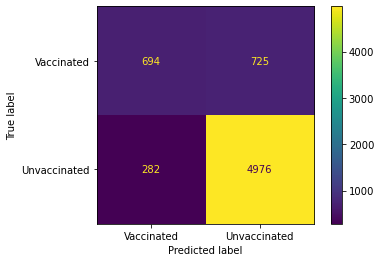

In [25]:
ConfusionMatrixDisplay.from_predictions(y_test, test_pred, display_labels=['Vaccinated', 'Unvaccinated'])

In [26]:
accuracy_score(y_test, test_pred), accuracy_score(y_train, train_pred)

(0.8491837651639959, 0.8636045931103346)

In [27]:
precision_score(y_test, test_pred)

0.8728293281880372

In [28]:
recall_score(y_test, test_pred)

0.9463674400912895

In [29]:
roc_auc_score(y_test, test_pred)

0.7177221273747497

In [30]:
balanced_accuracy_score(y_test, test_pred)

0.7177221273747497

### Conclusions

Metric | Score
-------|------
Accuracy| 0.849
Precision| 0.873
Recall| 0.956
Roc_Auc| 0.717